## Importando os datasets 

In [1]:
import pandas as pd
import numpy as np

train_data_all = pd.read_csv('train.csv')
test_data_all = pd.read_csv('test.csv')

train_data_all.info()
test_data_all.info()
train_data_all.isnull().sum()
test_data_all.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Colunas faltando: Age; Cabin; Embarked


## Removendo as colunas Cabin,  Embarked, Name e Ticket colocando a média na Age

In [2]:
from sklearn.impute import SimpleImputer

train_data = train_data_all.drop(['Embarked', 'Cabin', 'Name', 'Ticket'], axis=1)
test_data = test_data_all.drop(['Embarked', 'Cabin', 'Name', 'Ticket'], axis=1)

imputer = SimpleImputer(strategy='median')

train_data['Age'] = imputer.fit_transform(train_data[['Age']])
test_data['Age'] = imputer.fit_transform(test_data[['Age']])
test_data['Fare'] = imputer.fit_transform(test_data[['Fare']])

train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0})
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0})

train_data.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

##  Prepararando os dados 

In [3]:

X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
X_test = test_data


## Treinando os modelos

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)

svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

output_logistic = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_pred_logistic})
output_logistic.to_csv('logistic_regression_predictions.csv', index=False)

output_svm = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_pred_svm})
output_svm.to_csv('svm_predictions.csv', index=False)

## Resultados

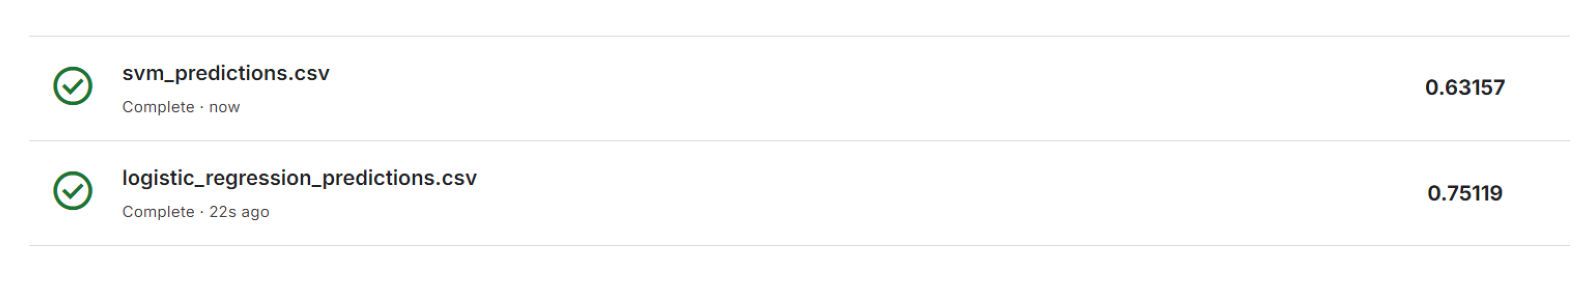

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('Resultados.png') 
plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(img)
plt.axis('off') 
plt.show()

## Melhorando os resultados:

In [13]:
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline

train_data=train_data_all
test_data=test_data_all

train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']

train_data = train_data.drop(['SibSp', 'Parch', 'Embarked', 'Cabin'], axis=1)
test_data = test_data.drop(['SibSp', 'Parch', 'Embarked', 'Cabin'], axis=1)

def extract_title(name):
    if pd.isnull(name):
        return "Unknown"
    return name.split(',')[1].split('.')[0].strip()

train_data['Title'] = train_data['Name'].apply(extract_title)
test_data['Title'] = test_data['Name'].apply(extract_title)

train_data = train_data.drop(['Name', 'Ticket'], axis=1)
test_data = test_data.drop(['Name', 'Ticket'], axis=1)

titles = ['Mr', 'Miss', 'Mrs', 'Master']
train_data['Title'] = train_data['Title'].apply(lambda x: x if x in titles else 'Rare')
test_data['Title'] = test_data['Title'].apply(lambda x: x if x in titles else 'Rare')

label_encoder = LabelEncoder()
train_data['Title'] = label_encoder.fit_transform(train_data['Title'])
test_data['Title'] = label_encoder.transform(test_data['Title'])

train_data['Age'] = imputer.fit_transform(train_data[['Age']])
test_data['Age'] = imputer.transform(test_data[['Age']])

age_bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
train_data['AgeGroup'] = age_bins.fit_transform(train_data[['Age']])
test_data['AgeGroup'] = age_bins.transform(test_data[['Age']])

train_data = train_data.drop(['Age'], axis=1)
test_data = test_data.drop(['Age'], axis=1)

train_data['Alone'] = (train_data['FamilySize'] == 0).astype(int)
test_data['Alone'] = (test_data['FamilySize'] == 0).astype(int)

train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0})
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0})

test_data['Fare'] = imputer.fit_transform(test_data[['Fare']])

X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
X_test = test_data

C=0.74

logistic_model = LogisticRegression(max_iter=200, C=C, solver='liblinear')
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)

svm_model = SVC(C=C, kernel='sigmoid')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

output_logistic = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_pred_logistic})
output_logistic.to_csv(f'logistic_regression_predictionsc{C}.csv', index=False)

output_svm = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_pred_svm})
output_svm.to_csv(f'svm_predictionsc{C}.csv', index=False)


## Melhor resultado

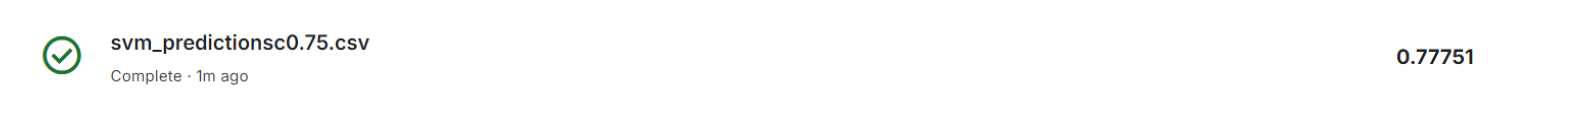

In [14]:
img = mpimg.imread('Resultados2.png') 
plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(img)
plt.axis('off') 
plt.show()